# Multi-materials simulation

In this demo, we will perform a multi-materials simulation. This will be our problem case.
The following FESTIM features will be used:
- Multi-materials
- Meshing:
    - mesh from vertices
- Boundary conditions:
    - Recombination flux
- Exports:
    - txt exports
    - Flux computations
    - Integrations over volumes for inventories calculation
- Plotting with matplotlib

## 1. Problem definition
The domain is a composite slab W/Cu/W as described below:
 <p align="center">
  <img src="https://user-images.githubusercontent.com/40028739/104934903-e10d7500-59aa-11eb-9296-17de99140701.jpg" width="40%">
</p>

- $\Omega = [0;1.5\times10^{-7}]$
- $\Omega_1 = [0;5\times10^{-8}]$ (W left)
- $\Omega_2 = [5\times10^{-8};1\times10^{-7}] $ (Cu)
- $\Omega_3 = [1\times10^{-7};1.5\times10^{-7}]$ (W right)
- $D(T) = \begin{cases}
    4.1\times 10^{-7} \exp{(-0.39/k_B T)}, & \text{on } \Omega_1 \text{ and } \Omega_3\\
    1.5\times 10^{-7} \exp{(-0.15/k_B T)}, & \text{on } \Omega_2
    \end{cases}$
- Trap 1 in $\Omega_2$ and $\Omega_3$:
    - Density: $n_1 = 1.3\times 10^{-3} \text{ at.fr.}$
    - Trapping rate: $k(T) = 3.8 \times 10^{-17} \exp{(-0.39/k_B T)} \text{ s}^{-1}$
    - Detrapping rate: $p(T) = 8.4\times 10^{12} \exp{(-1.2/k_B T)} \text{ s}^{-1}$
- Trap 2 in $\Omega_2$:
    - Density: $n_2 = 5\times10^{-5} \text{ at.fr.}$
    - Trapping rate: $k(T) = 6 \times 10^{-17} \exp{(-0.39/k_B T)} \text{ s}^{-1}$
    - Detrapping rate: $p(T) = 8\times10^{13} \exp{(-1.0/k_B T)} \text{ s}^{-1}$


A Dirichlet boundary conditions will be imposed on $\Gamma_\mathrm{left}$ and a recombination flux is imposed on $\Gamma_\mathrm{right}$.

- $c_\mathrm{m} = 10^{20} \; \mathrm{m}^{-3} \quad \text{on } \Gamma_\mathrm{left}$
- $-D \nabla c_\mathrm{m} \cdot n = -K c_\mathrm{m}^2 \quad \text{on }\Gamma_\mathrm{right}$
with $K = 2.9\times 10^{-14} \exp{(-1.92/k_B T)} \; \mathrm{m}^4 \mathrm{s}^{-1}$

## 2. Implementation
The first step is to create an empty parameters dictionnary

In [1]:
import FESTIM as F

my_model = F.Simulation()

### 2.1 Materials.

`"borders"` represents the boundaries of the 1D domain in $\text{m}$.

`"E_D"` is the energy barrier for diffusion expressed in $\text{eV}$.

`"D_0"` is the pre-exponential factor of the Arhenius' law for the diffusion coefficient expressed in $\text{m}^{2}\text{s}^{-1}$.

Finally, `"id"` is the id of the material subdomain. This will be needed later on.

In [2]:
tungsten_left = F.Material(
    id=1,
    D_0=4.1e-7,
    E_D=0.39,
    borders=[0, 0.5e-7]
    )

copper = F.Material(
    id=2,
    D_0=1.5e-7,
    E_D=0.15,
    borders=[0.5e-7, 1e-7]
    )

tungsten_right = F.Material(
    id=3,
    D_0=4.1e-7,
    E_D=0.39,
    borders=[1e-7, 1.5e-7]
    )

my_model.materials = F.Materials([tungsten_left, copper, tungsten_right])

### 2.2 Meshing
Now it's time to create a mesh for our simulation. One way of creating a 1D mesh in FESTIM is to directly provide the mesh coordinates (vertices). In this case, we want 200 nodes in the left sub-domain, 100 nodes in the middle one and finally 200 cells in right sub-domain.

In [3]:
import numpy as np

vertices = np.unique(np.concatenate(
        [np.linspace(0, 0.5e-7, num=200),
        np.linspace(0.5e-7, 1e-7, num=100),
        np.linspace(1e-7, 1.5e-7, num=200)]))

my_model.mesh = F.MeshFromVertices(vertices)

### 2.3 Traps
In FESTIM, each trap is defined by a dictionary with the following keys:

`"k_0"` and `"E_k"` are the trapping rate pre-exponential factor in $\text{m}^{3} \text{s}^{-1}$ and activation energy in $\text{eV}$.

`"p_0"` and `"E_p"` are the detrapping rate pre-exponential factor in $\text{s}^{-1}$ and activation energy in $\text{eV}$.

`"materials"` is a list of the materials' ids where the trap is.

For this example, there will be one trap in the tungsten parts (`trap_tunsgten`) and a trap in the copper layer (`trap_copper`).

In [4]:
tungsten_density = 6.3e28

trap_tungsten = F.Trap(
    k_0=3.8e-17,
    E_k=0.39,
    p_0=8.4e12,
    E_p=1.2,
    density=1.3e-3*tungsten_density,
    materials=[1, 3]
)

copper_density = 8.43e28

trap_copper = F.Trap(
    k_0=6e-17,
    E_k=0.39,
    p_0=8e13,
    E_p=0.9,
    density=5e-5*copper_density,
    materials=[2]
)

my_model.traps = F.Traps([trap_tungsten, trap_copper])

### 2.4 Temperature
The temperature in this example will be $320 \text{K}$ in the whole domain.

In [5]:
my_model.T = F.Temperature(320)

### 2.5 Boundary conditions
A Dirichlet boundary condition is imposed on the left surface (1) whereas a second order recombination flux is assumed on the right surface.

In [6]:
left_bc = F.DirichletBC(
    surfaces=1,
    value=1e20
    )

right_bc = F.RecombinationFlux(
    surfaces=2,
    Kr_0=2.9e-10,
    E_Kr=1,
    order=2
    )

my_model.boundary_conditions = [left_bc, right_bc]

### 2.6 Exports
All the output files will be exported in a directory named **outputs**.
The two types of derived quantities we are interested in are **volume integrations** of the solute and trapped concentrations as well as the computation of **fluxes on surfaces**.

In [7]:
folder = 'outputs'

derived_quantities = F.DerivedQuantities(file="derived_quantities.csv", folder=folder)
derived_quantities.derived_quantities = [
    F.TotalVolume(field="retention", volume=1),
    F.TotalVolume(field="retention", volume=2),
    F.TotalVolume(field="retention", volume=3),
    F.TotalVolume(field="1", volume=1),
    F.TotalVolume(field="1", volume=3),
    F.TotalVolume(field="2", volume=2),
    F.SurfaceFlux(field="solute", surface=1),
    F.SurfaceFlux(field="solute", surface=2),
]

txt_exports = F.TXTExports(
    fields=['1', '2', 'solute', 'retention'],
    labels=['trap1', 'trap2', 'mobile', 'retention'],
    times=[2000, 17000, 20000],
    folder=folder
    )

my_model.exports = F.Exports([derived_quantities] + txt_exports.exports)

### 2.7 Solving parameters
The simulation will last $17 000$ s and the initial stepsize is $50$ s.

It is recommended to set the `"traps_element_type"` key to `"DG"` (Discontinuous Galerkin) when dealing with multiple materials. This is because the trapped concentration fields won't be continuous (discontinuities at interfaces) and could lead to interpolation issues.

In [8]:
my_model.settings = F.Settings(
    absolute_tolerance=1e10,
    relative_tolerance=1e-09,
    final_time=2e4,
    traps_element_type="DG",
    maximum_iterations=50
)


my_model.dt = F.Stepsize(
    initial_value=50,
    stepsize_change_ratio=1.1,
    dt_min=1e-5)

### 2.8 Run the simulation

In [9]:
my_model.initialise()
my_model.run()

Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...
Solved problem in 1.80 s    Ellapsed time so far: 1.7 s


{'mesh': <dolfin.cpp.mesh.Mesh at 0x7f7da4043258>,
 'derived_quantities': [['t(s)',
   'Total retention volume 1',
   'Total retention volume 2',
   'Total retention volume 3',
   'Total 1 volume 1',
   'Total 1 volume 3',
   'Total 2 volume 2',
   'Flux surface 1: solute',
   'Flux surface 2: solute'],
  [50.0,
   1.2154095530966952e+17,
   21926811466257.918,
   1711876958691347.5,
   1.2153979731554736e+17,
   1711861680149630.0,
   21860189536372.9,
   2440862420931044.0,
   -9686168578.538828],
  [105.0,
   2.490179334810593e+17,
   23938722612652.367,
   3698120641247138.0,
   2.4901674801146832e+17,
   3698104507393279.5,
   23868398638463.066,
   2332481368433459.0,
   -10235755761.65905],
  [165.5,
   3.822536312588292e+17,
   25259026259170.414,
   5998709061827591.0,
   3.822524157685639e+17,
   5998692051576076.0,
   25184914937591.152,
   2221884204735016.2,
   -10799978212.303385],
  [232.05,
   5.2102417370304186e+17,
   26730164028368.984,
   8673955081593979.0,
   5.21

## 3. Post-processing
We can now plot the derived quantities computed with FESTIM

### 3.1 Inventories

Text(0.5, 0, 'Time (s)')

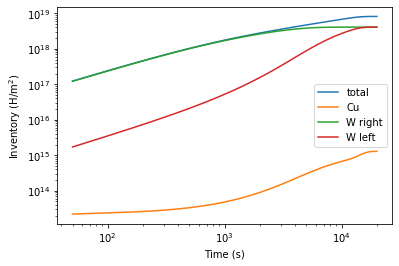

In [10]:
import matplotlib.pyplot as plt

# from the csv file
data = np.genfromtxt(folder + "/derived_quantities.csv", delimiter=",", names=True)
t = data["ts"]
ret_cu = data["Total_retention_volume_2"]
ret_w_left = data["Total_retention_volume_1"]
ret_w_right = data["Total_retention_volume_3"]


# alternatively from the DerivedQuantity object
data = np.array(derived_quantities.data[1:])
t = data[:, 0]
ret_cu = data[:, 2]
ret_w_left = data[:, 3]
ret_w_right = data[:, 1]

total = ret_cu + ret_w_left + ret_w_right

plt.figure()
plt.plot(t, total, label="total")
plt.plot(t, ret_cu, label="Cu")
plt.plot(t, ret_w_right, label="W right")
plt.plot(t, ret_w_left, label="W left")
plt.yscale("log")
plt.xscale("log")
plt.legend()
plt.ylabel("Inventory (H/m$^2$)")
plt.xlabel("Time (s)")

### 3.2 Particle fluxes

(-150000000000000.0, 260000000000000.0)

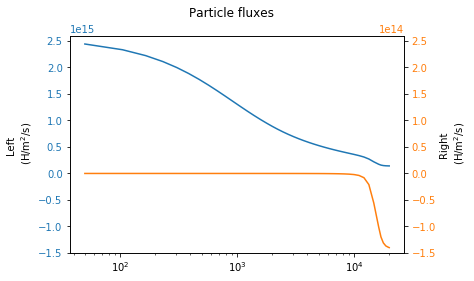

In [11]:
flux_left = data[:, -2]
flux_right = data[:, -1]

fig, ax1 = plt.subplots()
fig.suptitle('Particle fluxes')
color = "tab:blue"
ax1.plot(t, flux_left)
ax1.set_ylabel("Left \n (H/m$^2$/s)")
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim(-1.5e15, 2.6e15)

ax2 = ax1.twinx()
color = "tab:orange"
ax2.plot(t, flux_right, color=color)
ax2.set_ylabel("Right \n (H/m$^2$/s)")
ax2.set_xlabel("Time (s)")
ax2.set_xscale("log")
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(-1.5e14, 2.6e14)

### 3.3 Trap profiles

Text(0, 0.5, 'retention (H/m$^3$)')

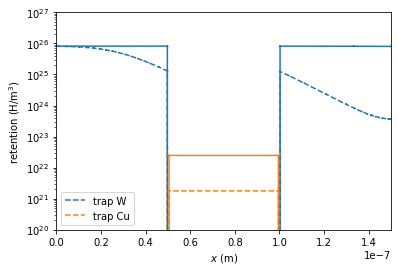

In [12]:
trap_W_1 = np.genfromtxt(folder + '/trap1_2000.0s.txt')
trap_W_2 = np.genfromtxt(folder + '/trap1_17000.0s.txt')
trap_cu_1 = np.genfromtxt(folder + '/trap2_2000.0s.txt')
trap_cu_2 = np.genfromtxt(folder + '/trap2_17000.0s.txt')

plt.figure()
plt.xlim(0, 1.5e-7)
plt.ylim(bottom=1e20, top=1e27)
plt.plot(trap_W_1[:, 0], trap_W_1[:, 1], label="trap W", color="tab:blue", linestyle='--')
plt.plot(trap_cu_1[:, 0], trap_cu_1[:, 1], label="trap Cu", color="tab:orange", linestyle='--')
plt.plot(trap_W_2[:, 0], trap_W_2[:, 1], color="tab:blue")
plt.plot(trap_cu_2[:, 0], trap_cu_2[:, 1], color="tab:orange")
plt.legend()
plt.yscale("log")
plt.xlabel("$x$ (m)")
plt.ylabel("retention (H/m$^3$)")

### 3.4 Solute profiles

Text(0, 0.5, 'solute concentration (H/m$^3$)')

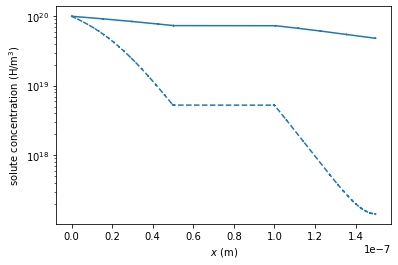

In [13]:
mobile_1 = np.genfromtxt(folder + '/mobile_2000.0s.txt')
mobile_2 = np.genfromtxt(folder + '/mobile_17000.0s.txt')

plt.figure()
plt.plot(mobile_1[:, 0], mobile_1[:, 1], linestyle="--")
plt.plot(mobile_2[:, 0], mobile_2[:, 1], color="tab:blue")
plt.yscale("log")
plt.xlabel("$x$ (m)")
plt.ylabel("solute concentration (H/m$^3$)")

## 4.  Conservation of chemical potential at interfaces
Note how the solute concentration is continuous across interfaces.

A more relevant interface model includes conservation of chemical potential across the interfaces.
This can be done with FESTIM by simply providing the **solubility** parameters for the materials.

More details can be found in [Delaporte-Mathurin _et al_ (Nuclear Fusion, 2021)](https://iopscience.iop.org/article/10.1088/1741-4326/abd95f).

In [14]:
# Add the solubility to the materials
tungsten_left.S_0 = 1.87e24
tungsten_left.E_S = 1.04
copper.S_0 = 3.14e24
copper.E_S = 0.57
tungsten_right.S_0 = 1.87e24
tungsten_right.E_S = 1.04

# tolerance is increased for better convergence

my_model.settings.absolute_tolerance = 1e12
my_model.settings.chemical_pot = True

my_model.initialise()
my_model.t = 0
my_model.dt.value.assign(50)
my_model.initialise()
my_model.run()

Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...
Solved problem in 3.00 s    Ellapsed time so far: 3.0 s


{'mesh': <dolfin.cpp.mesh.Mesh at 0x7f7da4043258>,
 'derived_quantities': [['t(s)',
   'Total retention volume 1',
   'Total retention volume 2',
   'Total retention volume 3',
   'Total 1 volume 1',
   'Total 1 volume 3',
   'Total 2 volume 2',
   'Flux surface 1: solute',
   'Flux surface 2: solute'],
  [50.0,
   1.1987643069490174e+17,
   3446239100852318.0,
   6461375645.176015,
   1.1987528774258309e+17,
   6461318029.800391,
   3435596654108107.0,
   2441820763639829.0,
   -36292.9541219174],
  [105.0,
   2.4543251212830074e+17,
   7416034698546355.0,
   21765943509.80129,
   2.454313426824285e+17,
   21765819442.662064,
   7393118031016718.0,
   2333584235950779.0,
   -78151.9811235867],
  [165.5,
   3.764570887073476e+17,
   1.2005929892946356e+16,
   49471224237.56982,
   3.76455890281497e+17,
   49471020054.41093,
   1.196821549828103e+16,
   2223155132034109.0,
   -128622.15902041887],
  [232.05,
   5.126747921080692e+17,
   1.7333569510985648e+16,
   94532084874.45215,
   5

**Have the outputs been impacted ?**

It appears the inventories aren't that much affected though the kinetics seem to be a tad slower.

Text(0.5, 0, 'Time (s)')

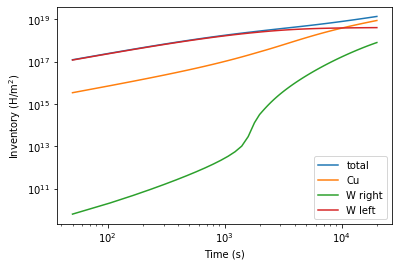

In [15]:
data_2 = np.array(derived_quantities.data[1:])
t = data_2[:, 0]
ret_w_left = data_2[:, 1]
ret_cu = data_2[:, 2]
ret_w_right = data_2[:, 3]

retention = ret_w_left + ret_cu + ret_w_right

plt.figure()
plt.plot(t, retention, label="total")
plt.plot(t, ret_cu, label="Cu")
plt.plot(t, ret_w_right, label="W right")
plt.plot(t, ret_w_left, label="W left")
plt.yscale("log")
plt.xscale("log")
plt.legend()
plt.ylabel("Inventory (H/m$^2$)")
plt.xlabel("Time (s)")

When plotting the solute particles concentration profiles, one can now observe the **concentration jumps** at interfaces induced by the difference in solubilities.

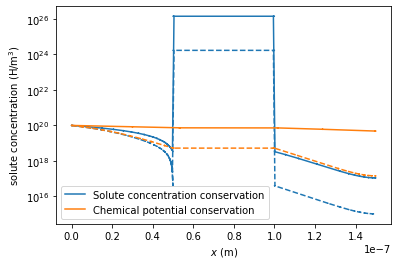

In [16]:
solute_1_chemical_potential = np.genfromtxt(folder + '/mobile_2000.0s.txt')
solute_2_chemical_potential = np.genfromtxt(folder + '/mobile_17000.0s.txt')

plt.figure()
plt.plot(solute_1_chemical_potential[:, 0], solute_1_chemical_potential[:, 1], linestyle="--")
plt.plot(solute_2_chemical_potential[:, 0], solute_2_chemical_potential[:, 1],
         color="tab:blue", label="Solute concentration conservation")

plt.plot(mobile_1[:, 0], mobile_1[:, 1], linestyle="--")
plt.plot(mobile_2[:, 0], mobile_2[:, 1], color="tab:orange", label="Chemical potential conservation")

plt.yscale("log")
plt.xlabel("$x$ (m)")
plt.ylabel("solute concentration (H/m$^3$)")
plt.legend()

ValueError: x and y must have same first dimension, but have shapes (75,) and (43,)

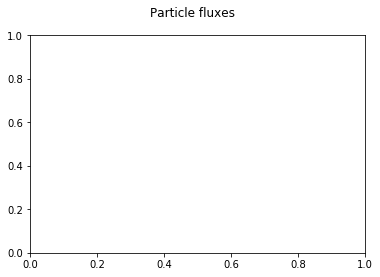

In [17]:
flux_left = data_2[:, -2]
flux_right = data_2[:, -1]

fig, ax1 = plt.subplots()
fig.suptitle('Particle fluxes')
color = "tab:blue"
ax1.plot(t, flux_left)
ax1.set_ylabel("Left \n (H/m$^2$/s)")
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim(-5e15, 2.6e15)

ax2 = ax1.twinx()
color = "tab:orange"
ax2.plot(t, flux_right, color=color)
ax2.set_ylabel("Right \n (H/m$^2$/s)")
ax2.set_xlabel("Time (s)")
ax2.set_xscale("log")
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(-5e10, 2.6e10)